In [146]:
import numpy as np 
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import time
import datetime
from datetime import datetime
import calendar

from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix


sns.set_style('white')

pd.options.display.float_format = '{:,.2f}'.format

In [147]:
# reduces the memory of a dataframe
def reduce_mem_usage(df, verbose = True):
    
    '''
    Reduces the space that a DataFrame occupies in memory.

    This function iterates over all columns in a df and downcasts them to lower type to save memory.
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [148]:
df_sorted = pd.read_pickle('../Datos-Easymoney/EasyMoney_base.pkl',compression='zip')

In [149]:
df_sorted.isnull().sum().sum()

0

In [150]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 59 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_cid                  int32         
 1   pk_partition            datetime64[ns]
 2   short_term_deposit      int8          
 3   loans                   int8          
 4   mortgage                int8          
 5   funds                   int8          
 6   securities              int8          
 7   long_term_deposit       int8          
 8   em_account_pp           int8          
 9   credit_card             int8          
 10  payroll                 float16       
 11  pension_plan            float16       
 12  payroll_account         int8          
 13  emc_account             int8          
 14  debit_card              int8          
 15  em_account_p            int8          
 16  em_acount               int8          
 17  entry_date              datetime64[ns]
 18  en

# Variable dif_cuentaSimple:

In [151]:
df_sorted.loc[ (df_sorted['dif_debit_card']==1) | 
               (df_sorted['dif_em_account_p']==1) |
               (df_sorted['dif_em_account_pp']==1) |
               (df_sorted['dif_em_acount']==1) |
               (df_sorted['dif_emc_account']==1) |
               (df_sorted['dif_payroll']==1) |
               (df_sorted['dif_payroll_account']==1), 'dif_cuentaSimple']=1

# Variable dif_ahorroInversion:

In [152]:
df_sorted.loc[ (df_sorted['dif_funds']==1) | 
               (df_sorted['dif_long_term_deposit']==1) |
               (df_sorted['dif_mortgage']==1) |
               (df_sorted['dif_pension_plan']==1) |
               (df_sorted['dif_securities']==1) |
               (df_sorted['short_term_deposit']==1) , 'dif_ahorroInversion']=1

# Variable dif_financiacion:

In [153]:
df_sorted.loc[ (df_sorted['loans']==1) | 
               (df_sorted['dif_credit_card']==1)  , 'dif_financiacion']=1

# Fill nans

In [154]:
df_sorted['dif_cuentaSimple'].fillna(0,inplace=True)
df_sorted['dif_ahorroInversion'].fillna(0,inplace=True)
df_sorted['dif_financiacion'].fillna(0,inplace=True)

In [155]:
cuentas_easymoney = ['dif_debit_card','dif_em_account_p','dif_em_account_pp',
                                     'dif_em_acount','dif_emc_account','dif_payroll','dif_payroll_account',
                    'dif_cuentaSimple']

In [156]:
df_sorted[df_sorted['pk_cid']==1035440  ][cuentas_easymoney].head(10).T

,451204,451205,451206,451207,451208,451209,451210,451211,451212,451213
dif_debit_card,0.00,0.00,0.00,0.00,-1.00,1.00,0.00,0.00,0.00,0.00
dif_em_account_p,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_em_account_pp,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_em_acount,0.00,-1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_emc_account,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_payroll,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_payroll_account,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_cuentaSimple,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


In [157]:
df_sorted.isnull().sum().sum()

0

# Vamos a hacer el producto cartesiano para predecir
Solo clientes activos(Con producto)

In [158]:
lista_fechas=['2018-01-28',
'2018-02-28',
'2018-03-28',
'2018-04-28',
'2018-05-28',
'2018-06-28',
'2018-07-28',
'2018-08-28',
'2018-09-28',
'2018-10-28',
'2018-11-28',
'2018-12-28',
'2019-01-28',
'2019-02-28',
'2019-03-28',
'2019-04-28',
'2019-05-28',             
'2019-06-28']

In [159]:
lista_clientes=df_sorted[(df_sorted['isActive']==1) & 
                        (df_sorted['pk_partition']=='2019-05-28')]["pk_cid"].unique().tolist()

In [160]:
len(lista_clientes)

331588

In [161]:
cartesian_product = pd.MultiIndex.from_product([lista_fechas, lista_clientes ], names = ["pk_partition", "pk_cid"])
len(cartesian_product)

5968584

In [162]:
cartesian_product

MultiIndex([('2018-01-28',   16203),
            ('2018-01-28',   16502),
            ('2018-01-28',   17457),
            ('2018-01-28',   17799),
            ('2018-01-28',   17970),
            ('2018-01-28',   17980),
            ('2018-01-28',   18146),
            ('2018-01-28',   18704),
            ('2018-01-28',   19021),
            ('2018-01-28',   19268),
            ...
            ('2019-06-28', 1553390),
            ('2019-06-28', 1553393),
            ('2019-06-28', 1553415),
            ('2019-06-28', 1553429),
            ('2019-06-28', 1553436),
            ('2019-06-28', 1553456),
            ('2019-06-28', 1553541),
            ('2019-06-28', 1553559),
            ('2019-06-28', 1553565),
            ('2019-06-28', 1553571)],
           names=['pk_partition', 'pk_cid'], length=5968584)

In [163]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df.tail()

,pk_partition,pk_cid
5968579,2019-06-28,1553456
5968580,2019-06-28,1553541
5968581,2019-06-28,1553559
5968582,2019-06-28,1553565
5968583,2019-06-28,1553571


In [164]:
full_df['pk_partition']=pd.to_datetime(full_df['pk_partition'], format='%Y-%m-%d')

In [165]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    331588
2018-02-28    331588
2018-03-28    331588
2018-04-28    331588
2018-05-28    331588
2018-06-28    331588
2018-07-28    331588
2018-08-28    331588
2018-09-28    331588
2018-10-28    331588
2018-11-28    331588
2018-12-28    331588
2019-01-28    331588
2019-02-28    331588
2019-03-28    331588
2019-04-28    331588
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

In [166]:
full_df = pd.merge(full_df,df_sorted , on = ["pk_partition", "pk_cid"], how = 'left')

In [167]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    331588
2018-02-28    331588
2018-03-28    331588
2018-04-28    331588
2018-05-28    331588
2018-06-28    331588
2018-07-28    331588
2018-08-28    331588
2018-09-28    331588
2018-10-28    331588
2018-11-28    331588
2018-12-28    331588
2019-01-28    331588
2019-02-28    331588
2019-03-28    331588
2019-04-28    331588
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

In [168]:
del df_sorted

In [169]:
gc.collect()

160

In [170]:
#full_df.to_pickle('fulldf_base.pkl',compression='zip')

In [171]:
# Nulos debidos al producto cartesiano
full_df[full_df['entry_date'].isnull()].groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    105082
2018-02-28    102163
2018-03-28     99439
2018-04-28     97067
2018-05-28     94559
2018-06-28     92249
2018-07-28     75495
2018-08-28     64161
2018-09-28     46426
2018-10-28     29032
2018-11-28     19458
2018-12-28     15461
2019-01-28     10911
2019-02-28      7185
2019-03-28      4038
2019-04-28      1612
2019-06-28    331588
Name: pk_cid, dtype: int64

In [172]:
full_df

,pk_partition,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,totalBeneficio,hayAlta,diasDesdeUltimaAlta,diasDesdeUltimaAltaInt,hayBaja,diasDesdeUltimaBaja,diasDesdeUltimaBajaInt,dif_cuentaSimple,dif_ahorroInversion,dif_financiacion
0,2018-01-28,16203,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
1,2018-01-28,16502,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
2,2018-01-28,17457,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,90.00,0.00,1 days 00:00:00,1.00,0.00,1 days 00:00:00,1.00,0.00,0.00,0.00
3,2018-01-28,17799,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.00,1.00,0 days 00:00:00,0.00,0.00,1 days 00:00:00,1.00,1.00,0.00,0.00
4,2018-01-28,17970,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,50.00,0.00,1 days 00:00:00,1.00,0.00,1 days 00:00:00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5968579,2019-06-28,1553456,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
5968580,2019-06-28,1553541,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
5968581,2019-06-28,1553559,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan
5968582,2019-06-28,1553565,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,NaN,nan,nan,NaN,nan,nan,nan,nan


In [173]:
# Borramos todos los nulos que se generan por el producto cartesiano:
full_df.drop (full_df[ (full_df['pk_partition']!='2019-06-28') &
                       (full_df['entry_date'].isnull()) ].index, axis=0, inplace=True)

In [174]:
full_df[full_df['entry_date'].isnull()].groupby('pk_partition')['pk_cid'].size()

pk_partition
2019-06-28    331588
Name: pk_cid, dtype: int64

In [175]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    226506
2018-02-28    229425
2018-03-28    232149
2018-04-28    234521
2018-05-28    237029
2018-06-28    239339
2018-07-28    256093
2018-08-28    267427
2018-09-28    285162
2018-10-28    302556
2018-11-28    312130
2018-12-28    316127
2019-01-28    320677
2019-02-28    324403
2019-03-28    327550
2019-04-28    329976
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

In [176]:
# Actualizamos el mes a predecir:2019-06-28 con los valores de los clientes 
lista_actualizar=['entry_date',
 #'entry_channel',
 'active_customer',
 #'segment',
 #'country_id',
 'region_code',
 #'gender',
 'age',
 #'deceased', 
 #'mesesAlta',
'salary']

In [177]:
# Rellenamos entry_date para el ultimo mes:
for x in lista_actualizar:
    print(x)
    full_df.loc[(full_df['pk_partition']=='2019-06-28'),
            x]=full_df[full_df['pk_partition']=='2019-06-28']['pk_cid'].map(full_df[['pk_cid',x]].groupby('pk_cid')[x].max())

entry_date
active_customer
region_code
age
salary


In [178]:
# Solo tenemos nulos en el mes a predecir
full_df.isnull().sum()

pk_partition                   0
pk_cid                         0
short_term_deposit        331588
loans                     331588
mortgage                  331588
                           ...  
diasDesdeUltimaBaja       331588
diasDesdeUltimaBajaInt    331588
dif_cuentaSimple          331588
dif_ahorroInversion       331588
dif_financiacion          331588
Length: 62, dtype: int64

In [179]:
full_df[(full_df['isNewClient']==0) &
                     (full_df['isActive']==0)].T

,25,49,84,173,220,374,412,442,604,746,...,5303901,5303902,5303903,5303904,5303905,5303906,5303907,5303908,5303909,5303910
pk_partition,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,...,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00,2019-04-28 00:00:00
pk_cid,25612,35849,46823,83660,102549,151516,162194,173207,220336,271773,...,1548181,1548182,1548186,1548188,1548189,1548196,1548197,1548201,1548202,1548203
short_term_deposit,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loans,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mortgage,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
diasDesdeUltimaBaja,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,...,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
diasDesdeUltimaBajaInt,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
dif_cuentaSimple,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
dif_ahorroInversion,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [180]:
# Borramos los meses que no pasa nada para que el modelo aprenda a coger emjor los cambios.
#El rendimiento del modelo mejora con esto:
full_df.drop(full_df[(full_df['isNewClient']==0) &
                     (full_df['isActive']==0)].index ,axis=0, inplace=True)

In [181]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    225280
2018-02-28    228190
2018-03-28    231046
2018-04-28    233515
2018-05-28    236109
2018-06-28    238471
2018-07-28    250654
2018-08-28    263897
2018-09-28    280575
2018-10-28    298855
2018-11-28    308341
2018-12-28    312624
2019-01-28    317763
2019-02-28    321798
2019-03-28    325130
2019-04-28    328546
2019-05-28    331588
2019-06-28    331588
Name: pk_cid, dtype: int64

In [182]:
full_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5063970 entries, 2 to 5968583
Data columns (total 62 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_partition            datetime64[ns]
 1   pk_cid                  int64         
 2   short_term_deposit      float64       
 3   loans                   float64       
 4   mortgage                float64       
 5   funds                   float64       
 6   securities              float64       
 7   long_term_deposit       float64       
 8   em_account_pp           float64       
 9   credit_card             float64       
 10  payroll                 float16       
 11  pension_plan            float16       
 12  payroll_account         float64       
 13  emc_account             float64       
 14  debit_card              float64       
 15  em_account_p            float64       
 16  em_acount               float64       
 17  entry_date              datetime64[ns]
 18  en

In [183]:
#reduce_mem_usage(full_df, verbose = True)

In [184]:
#full_df.to_pickle('fulldf_base_nandropped_VII.pkl',compression='zip')

In [185]:
delta_productos_easymoney=['dif_loans',
 'dif_mortgage',
 'dif_funds',
 'dif_securities',
 'dif_long_term_deposit',
 'dif_short_term_deposit',                          
 'dif_em_account_pp',
 'dif_credit_card',
 'dif_payroll',
 'dif_pension_plan',
 'dif_payroll_account',
 'dif_emc_account',
 'dif_debit_card',
 'dif_em_acount',
 'dif_em_account_p',
 'dif_cuentaSimple',
 'dif_ahorroInversion',                       
 'dif_financiacion']

In [186]:
productos_easymoney=['loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'short_term_deposit',                    
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_acount',
 'em_account_p']

Ponemos a 0 las bajas para solo predecir altas:

In [187]:
for x in delta_productos_easymoney:
      full_df.loc[full_df[x]==-1, x ]=0  

In [188]:
full_df['dif_em_acount'].value_counts()

0.00    4613569
1.00     118813
Name: dif_em_acount, dtype: int64

In [189]:
full_df['dif_credit_card'].value_counts()

0.00    4721714
1.00      10668
Name: dif_credit_card, dtype: int64

In [190]:
#full_df.to_pickle('./fulldf_base_VII.pkl',compression='zip')

In [191]:
#full_df=pd.read_pickle('./fulldf_base_V1.pkl',compression='zip')

# Feature engeniering

In [ ]:
for y in delta_productos_easymoney:
    print(y)
    for x in [1,2,3,4]:
        print(x)
        full_df[y+'_shift_'+str(x)]=full_df.groupby(['pk_cid'])[y].shift(x)

dif_loans
1
2
3
4
dif_mortgage
1
2
3
4
dif_funds
1
2
3
4
dif_securities
1
2
3
4
dif_long_term_deposit
1
2
3
4
dif_short_term_deposit
1
2
3
4
dif_em_account_pp
1
2
3
4
dif_credit_card
1
2
3
4
dif_payroll
1
2


In [ ]:
for y in productos_easymoney:
    print(y)
    for x in [1,2,3,4]:
        print(x)
        full_df[y+'_shift_'+str(x)]=full_df.groupby(['pk_cid'])[y].shift(x)

In [ ]:
for x in [1,2,3,4]:
    print(x)
    full_df['isActive_shift_'+str(x)]=full_df.groupby(['pk_cid'])['isActive'].shift(x)
    full_df['isNewClient_shift_'+str(x)]=full_df.groupby(['pk_cid'])['isNewClient'].shift(x)
    full_df['active_customer_shift_'+str(x)]=full_df.groupby(['pk_cid'])['active_customer'].shift(x)
    full_df['totalAssets_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAssets'].shift(x)
    full_df['totalCuentas_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalCuentas'].shift(x)
    full_df['totalAhorro_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAhorro'].shift(x)
    full_df['totalFinanciacion_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalFinanciacion'].shift(x)
    full_df['totalIngresos_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalIngresos'].shift(x)
    #full_df['totalBeneficio_'+str(x)]=full_df.groupby(['pk_cid'])['totalBeneficio'].shift(x)
    full_df['diasDesdeUltimaAltaInt_shift_'+str(x)]=full_df.groupby(['pk_cid'])['diasDesdeUltimaAltaInt'].shift(x)
    full_df['hayAlta_shift_'+str(x)]=full_df.groupby(['pk_cid'])['hayAlta'].shift(x)
    full_df['diasDesdeUltimaBajaInt_shift_'+str(x)]=full_df.groupby(['pk_cid'])['diasDesdeUltimaAltaInt'].shift(x)
    full_df['hayBaja_shift_'+str(x)]=full_df.groupby(['pk_cid'])['hayAlta'].shift(x)

In [ ]:
# Rellenamos los nulos producidos en las shift
full_df.fillna(-999,inplace=True)

In [ ]:
full_df["day"] = full_df["pk_partition"].dt.day
full_df["year"] = full_df["pk_partition"].dt.year
full_df["month"] = full_df["pk_partition"].dt.month

In [ ]:
full_df["entry_date_day"] = full_df["entry_date"].dt.day
full_df["entry_date_year"] = full_df["entry_date"].dt.year
full_df["entry_date_month"] = full_df["entry_date"].dt.month

In [ ]:
full_df.info()

In [ ]:
#reduce_mem_usage(full_df, verbose = True)

In [ ]:
full_df['entry_channel'].value_counts(dropna=False).head(10)

In [ ]:
full_df.loc[full_df['entry_channel']==-999,'entry_channel']='XXX'

In [ ]:
full_df['entry_channel']=pd.Categorical(full_df['entry_channel'], categories=full_df['entry_channel'].value_counts(dropna=False).head(10).index.to_list())

In [ ]:
full_df['entry_channel'].value_counts(dropna=False)

In [ ]:
dummy_dataset = pd.get_dummies(full_df['entry_channel'],prefix='channel')

In [ ]:
dummy_dataset

In [ ]:
full_df = pd.concat([full_df,dummy_dataset],axis=1)

In [ ]:
full_df.info(verbose=True)

In [ ]:
full_df['country_id'].value_counts(dropna=False)

In [ ]:
full_df.loc[full_df['country_id']==-999,'country_id']='Other'

In [ ]:
full_df['country_id'].value_counts(dropna=False)

In [ ]:
dummy_dataset = pd.get_dummies(full_df['country_id'],prefix='country')

In [ ]:
full_df = pd.concat([full_df,dummy_dataset],axis=1)

In [ ]:
full_df

In [ ]:
#reduce_mem_usage(full_df, verbose = True)

In [ ]:
#full_df.to_pickle('../Datos-Easymoney/fulldf_base_FEOK_VII.pkl',compression='zip')

In [3]:
#full_df=pd.read_pickle('../Datos-Easymoney/fulldf_base_FEOK_VII.pkl',compression='zip')

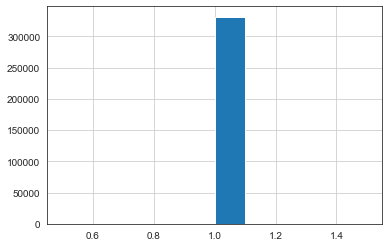

In [137]:
full_df[full_df['pk_partition']=='2019-05-28']['isActive'].hist()

In [139]:
full_df[full_df['pk_partition']=='2019-05-28']['isActive'].value_counts()

1.00    331588
Name: isActive, dtype: int64

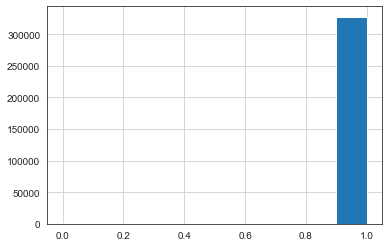

In [138]:
full_df[full_df['pk_partition']=='2019-04-28']['isActive'].hist()

In [140]:
full_df[full_df['pk_partition']=='2019-04-28']['isActive'].value_counts()

1.00    327738
0.00       808
Name: isActive, dtype: int64

In [143]:
full_df[full_df['pk_partition']=='2019-04-28']['isActive_shift_1'].value_counts()

1.00       324828
-999.00      2797
0.00          921
Name: isActive_shift_1, dtype: int64

In [145]:
full_df[full_df['pk_partition']=='2019-04-28']['isActive_shift_2'].value_counts()

1.00       320859
-999.00      6128
0.00         1559
Name: isActive_shift_2, dtype: int64

In [141]:
full_df[full_df['pk_partition']=='2019-03-28']['isActive'].value_counts()

1.00    324475
0.00       655
Name: isActive, dtype: int64

In [144]:
full_df[full_df['pk_partition']=='2019-03-28']['isActive_shift_1'].value_counts()

1.00       320622
-999.00      2962
0.00         1546
Name: isActive_shift_1, dtype: int64

In [142]:
full_df[full_df['pk_partition']=='2019-02-28']['isActive'].value_counts()

1.00    320406
0.00      1392
Name: isActive, dtype: int64

# Entrenar modelo

In [4]:
# split the data into train, validation and test dataset
train_index = sorted(list(full_df["pk_partition"].unique()))[5:-3]

valida_index = [sorted(list(full_df["pk_partition"].unique()))[-3]]

test_index = [sorted(list(full_df["pk_partition"].unique()))[-2]]

In [5]:
variables_borrar=['pk_cid',
'pk_partition',
'short_term_deposit',
'loans',
'mortgage',
'funds',
'securities',
'long_term_deposit',
'em_account_pp',
'credit_card',
'payroll',
'pension_plan',
'payroll_account',
'emc_account',
'debit_card',
'em_account_p',
'em_acount',
'entry_date',
'entry_channel',
'active_customer',
'segment',
'country_id',
'region_code',
'gender',
'age',
'deceased',
'salary',
'dif_debit_card',
'dif_em_account_p',
'dif_em_account_pp',
'dif_em_acount',
'dif_emc_account',
'dif_payroll',
'dif_payroll_account',
'dif_funds',
'dif_long_term_deposit',
'dif_mortgage',
'dif_pension_plan',
'dif_securities',
'dif_short_term_deposit',
'dif_loans',
'dif_credit_card',
'mesesAlta',
'isNewClient',
'isActive',
'Provincia',
'SalaryQtil',
'totalAssets',
'totalCuentas',
'totalAhorro',
'totalFinanciacion',
'totalIngresos',
'totalBeneficio',
'hayAlta',
'diasDesdeUltimaAlta',
'diasDesdeUltimaAltaInt',
'hayBaja',
'diasDesdeUltimaBaja',
'diasDesdeUltimaBajaInt',
'dif_cuentaSimple',
'dif_ahorroInversion',                       
'dif_financiacion']


In [107]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test

In [108]:
gc.collect()

52476

In [6]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_cuentaSimple']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_cuentaSimple']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_cuentaSimple']




In [101]:
dt = DecisionTreeClassifier(max_depth=6,random_state=42, min_samples_split=10000)
    

In [102]:
dt.fit(X_train,Y_train)
    

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [103]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.966282947718179 - Test: 0.9699433260487116


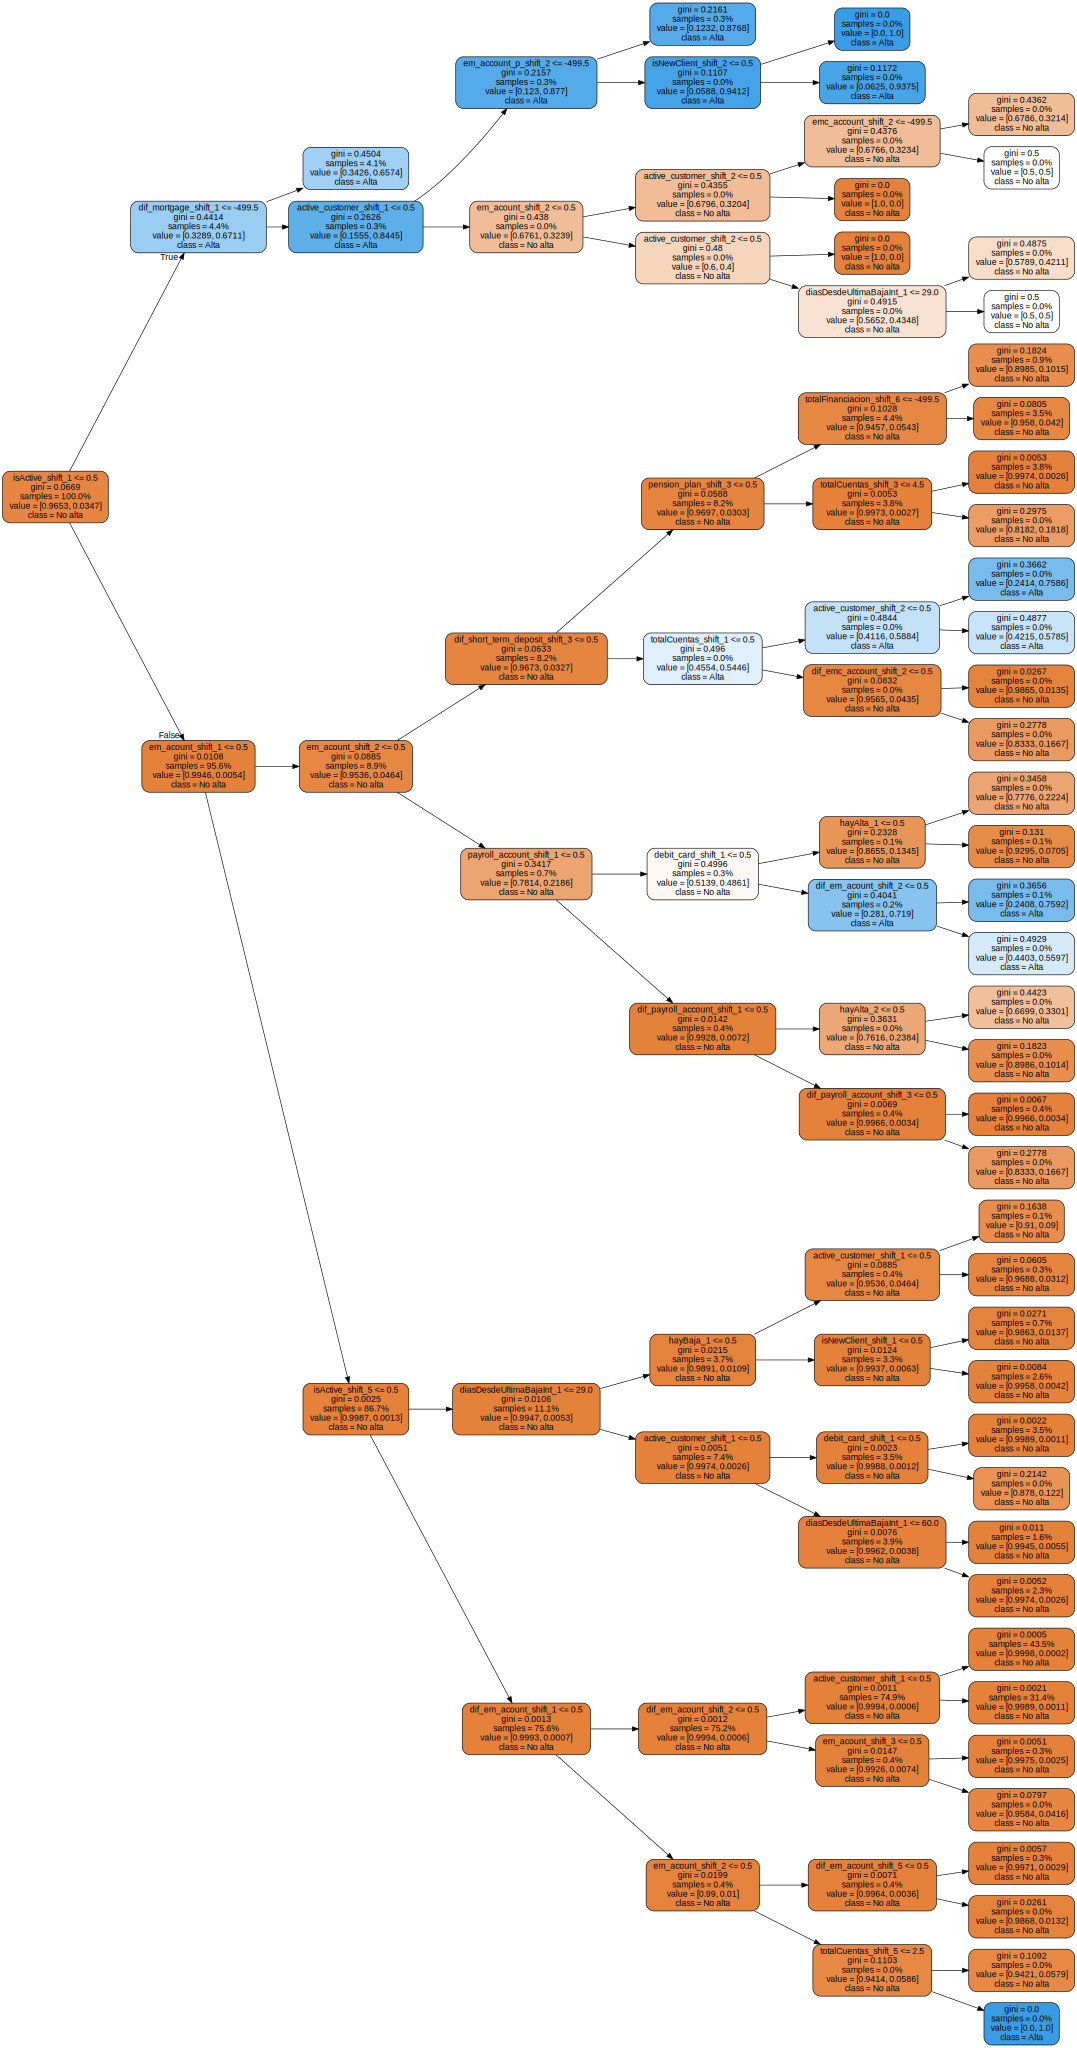

In [12]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        # out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No alta', 'Alta'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

In [14]:
type(graph)

graphviz.files.Source

In [16]:
graph.render(filename='arbol_EasyMoney')

'arbol_EasyMoney.pdf'

# Vemos con Test

In [104]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])

In [105]:
len(y_test_pred)

331588

In [106]:
score_test=dt.score(X_test, Y_test)

In [107]:
score_test

0.9699024090135951

In [108]:
results_df = Y_test.to_frame().join(y_test_pred)

In [109]:
results_df['Success']=(results_df['dif_cuentaSimple']==results_df['altaPrediction']).astype(int)

In [110]:
results_df[results_df['dif_cuentaSimple']!=0].sample(20)

,dif_cuentaSimple,altaPrediction,Success
5451490,1.00,0.00,0
5635674,1.00,1.00,1
5509636,1.00,0.00,0
5541168,1.00,0.00,0
5388865,1.00,0.00,0
5636573,1.00,1.00,1
5484636,1.00,0.00,0
5631247,1.00,0.00,0
5443537,1.00,0.00,0
5535918,1.00,1.00,1


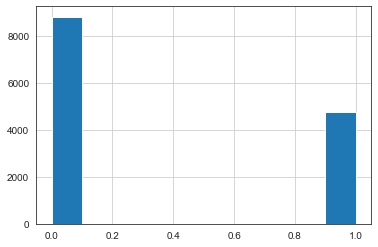

In [111]:
results_df[results_df['dif_cuentaSimple']==1]['Success'].hist()

In [112]:
results_df[results_df['dif_cuentaSimple']==1]['Success'].value_counts()

0    8819
1    4776
Name: Success, dtype: int64

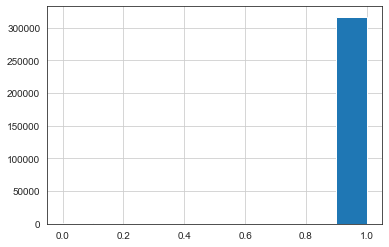

In [113]:
results_df[results_df['dif_cuentaSimple']==0]['Success'].hist()

In [114]:
results_df[results_df['dif_cuentaSimple']==0]['Success'].value_counts()

1    316832
0      1161
Name: Success, dtype: int64

In [115]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)

In [116]:
top_features

isActive_shift_1                 0.81
em_acount_shift_1                0.04
dif_pension_plan_shift_1         0.03
payroll_account_shift_1          0.02
debit_card_shift_2               0.02
totalAssets_shift_1              0.01
active_customer_shift_1          0.01
payroll_shift_2                  0.01
diasDesdeUltimaBajaInt_shift_2   0.01
entry_date_day                   0.01
entry_date_month                 0.01
channel_KHQ                      0.01
dif_short_term_deposit_shift_3   0.01
dif_debit_card_shift_3           0.00
debit_card_shift_1               0.00
channel_XXX                      0.00
pension_plan_shift_1             0.00
entry_date_year                  0.00
month                            0.00
channel_KHM                      0.00
debit_card_shift_4               0.00
channel_KAT                      0.00
dif_em_account_p_shift_2         0.00
dif_em_account_p_shift_1         0.00
dif_em_account_p_shift_3         0.00
dif_cuentaSimple_shift_2         0.00
dif_cuentaSi

# Curva Roc:

In [117]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)

In [118]:
results_df

,dif_cuentaSimple,altaPrediction,Success,AltaScore
5305408,0.00,0.00,1,0.03
5305409,0.00,0.00,1,0.03
5305410,1.00,0.00,0,0.16
5305411,0.00,0.00,1,0.03
5305412,0.00,0.00,1,0.01
...,...,...,...,...
5636991,0.00,1.00,0,0.60
5636992,0.00,1.00,0,0.60
5636993,0.00,1.00,0,0.60
5636994,0.00,1.00,0,0.60


In [119]:
results_df[results_df['dif_cuentaSimple']!=0].sample(20)

,dif_cuentaSimple,altaPrediction,Success,AltaScore
5634243,1.00,0.00,0,0.16
5636476,1.00,1.00,1,0.83
5625969,1.00,0.00,0,0.03
5531962,1.00,0.00,0,0.18
5375330,1.00,0.00,0,0.03
5350507,1.00,0.00,0,0.16
5520198,1.00,1.00,1,0.66
5379741,1.00,0.00,0,0.23
5628229,1.00,0.00,0,0.18
5464127,1.00,1.00,1,0.66


In [122]:
results_df['AltaScore'].value_counts(ascending=False).reset_index(name='Count')

,index,Count
0,0.00,159041
1,0.03,118673
2,0.16,10275
3,0.18,9364
4,0.01,8977
5,0.06,7888
6,0.14,4036
7,0.18,3522
8,0.08,1871
9,0.83,1794


In [96]:
results_by_score = results_df.pivot_table(index='AltaScore', values='Success', aggfunc=[len, sum, np.mean])
results_by_score.columns = ['Count', 'Sum', 'Mean']

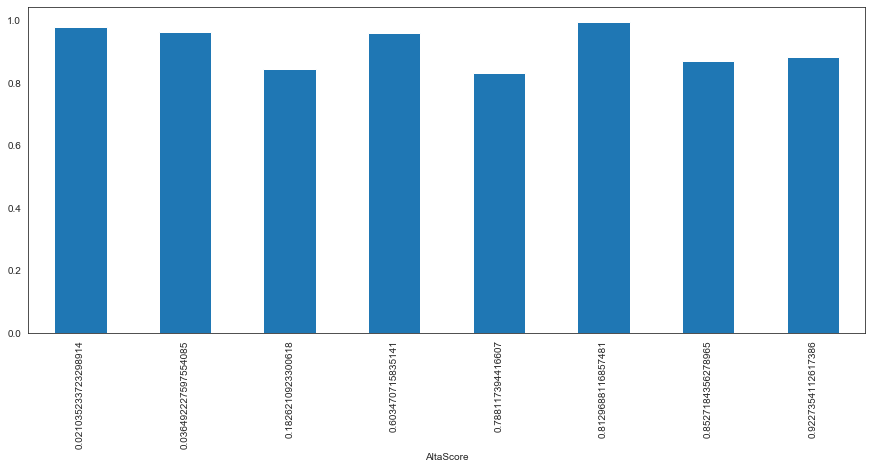

In [97]:
fig, ax = plt.subplots(figsize = (15, 6))
results_by_score['Mean'].plot(kind='bar')

# Curva AUC

In [123]:
print(metrics.roc_auc_score(results_df['dif_cuentaSimple'], results_df['AltaScore']))

0.882961718734913


In [124]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_cuentaSimple'], results_df['AltaScore'])

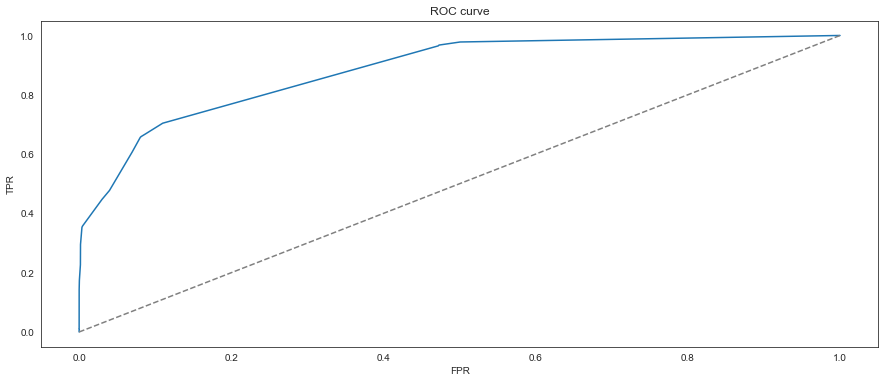

In [125]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

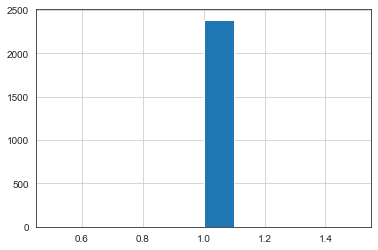

In [128]:
results_df[(results_df['dif_cuentaSimple']!=0) &
           (results_df['AltaScore']> 0.70) ]['Success'].hist()

In [133]:
results_df[(results_df['dif_cuentaSimple']!=0) &
           (results_df['AltaScore']> 0.50) ]['Success'].value_counts()

1    4776
Name: Success, dtype: int64

# Enternamos para ahorroInversion:

In [120]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test
gc.collect()


27938

In [121]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_ahorroInversion']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_ahorroInversion']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_ahorroInversion']

In [122]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [124]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.9901415574749118 - Test: 0.9918611092510637


In [125]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])


In [126]:
score_test=dt.score(X_test, Y_test)

In [127]:
score_test

0.9914894387010387

In [128]:
results_df = Y_test.to_frame().join(y_test_pred)

In [129]:
results_df['Success']=(results_df['dif_ahorroInversion']==results_df['altaPrediction']).astype(int)

In [130]:
results_df[results_df['dif_ahorroInversion']!=0].sample(20)

,dif_ahorroInversion,altaPrediction,Success
5624184,1.00,0.00,0
5388172,1.00,1.00,1
5539772,1.00,0.00,0
5390531,1.00,1.00,1
5454598,1.00,0.00,0
5381344,1.00,0.00,0
5605313,1.00,0.00,0
5555995,1.00,0.00,0
5450882,1.00,0.00,0
5493081,1.00,0.00,0


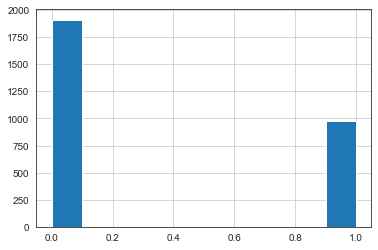

In [131]:
results_df[results_df['dif_ahorroInversion']==1]['Success'].hist()

In [132]:
results_df[results_df['dif_ahorroInversion']==1]['Success'].value_counts()

0    1912
1     973
Name: Success, dtype: int64

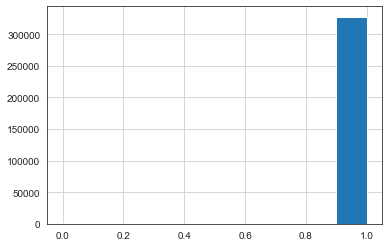

In [133]:
results_df[results_df['dif_ahorroInversion']==0]['Success'].hist()

In [134]:
results_df[results_df['dif_ahorroInversion']==0]['Success'].value_counts()

1    327793
0       910
Name: Success, dtype: int64

In [135]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)


In [136]:
top_features

short_term_deposit_shift_1       0.33
pension_plan_shift_2             0.24
pension_plan_shift_1             0.15
short_term_deposit_shift_3       0.09
payroll_account_shift_2          0.08
month                            0.04
age                              0.02
diasDesdeUltimaAltaInt_shift_2   0.01
totalAssets_shift_3              0.01
diasDesdeUltimaBajaInt_shift_1   0.01
payroll_shift_3                  0.01
short_term_deposit_shift_4       0.00
active_customer_shift_1          0.00
channel_XXX                      0.00
dif_pension_plan_shift_2         0.00
short_term_deposit_shift_2       0.00
entry_date_month                 0.00
payroll_shift_4                  0.00
debit_card_shift_1               0.00
isNewClient_shift_4              0.00
totalAhorro_shift_1              0.00
long_term_deposit_shift_1        0.00
dif_short_term_deposit_shift_4   0.00
year                             0.00
totalCuentas_shift_3             0.00
entry_date_day                   0.00
securities_s

In [137]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)


In [138]:
print(metrics.roc_auc_score(results_df['dif_ahorroInversion'], results_df['AltaScore']))

0.9031956041757334


In [139]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_ahorroInversion'], results_df['AltaScore'])

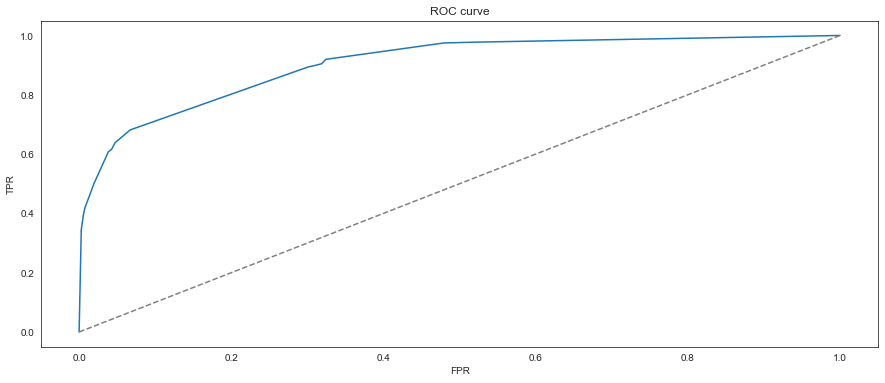

In [140]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [147]:
results_df[(results_df['dif_ahorroInversion']!=0) &
           (results_df['AltaScore']> 0.60) ]

,dif_ahorroInversion,altaPrediction,Success,AltaScore
5305793,1.00,1.00,1,0.65
5306156,1.00,1.00,1,0.65
5306773,1.00,1.00,1,0.65
5306878,1.00,1.00,1,0.65
5307103,1.00,1.00,1,0.65
...,...,...,...,...
5628414,1.00,1.00,1,0.65
5628630,1.00,1.00,1,0.65
5629217,1.00,1.00,1,0.65
5629602,1.00,1.00,1,0.65


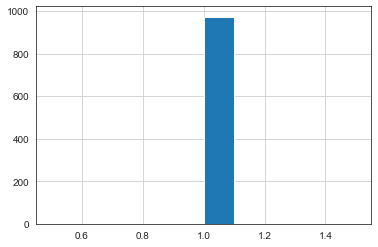

In [148]:
results_df[(results_df['dif_ahorroInversion']!=0) &
           (results_df['AltaScore']> 0.60) ]['Success'].hist()


In [149]:
results_df[(results_df['dif_ahorroInversion']!=0) &
           (results_df['AltaScore']> 0.60) ]['Success'].value_counts()


1    973
Name: Success, dtype: int64

# Enternamos para financiacion:

In [150]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test
gc.collect()


12264

In [151]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_financiacion']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_financiacion']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_financiacion']


In [152]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [153]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.9976529312828724 - Test: 0.9978450506169608


In [154]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])


In [155]:
score_test=dt.score(X_test, Y_test)

In [156]:
score_test

0.9976808569670796

In [157]:
results_df = Y_test.to_frame().join(y_test_pred)


In [158]:
results_df['Success']=(results_df['dif_financiacion']==results_df['altaPrediction']).astype(int)


In [159]:
results_df[results_df['dif_financiacion']!=0].sample(20)

,dif_financiacion,altaPrediction,Success
5549171,1.00,0.00,0
5384204,1.00,0.00,0
5616474,1.00,0.00,0
5461996,1.00,0.00,0
5316796,1.00,0.00,0
5306932,1.00,0.00,0
5472923,1.00,1.00,1
5363431,1.00,0.00,0
5467564,1.00,0.00,0
5310207,1.00,0.00,0


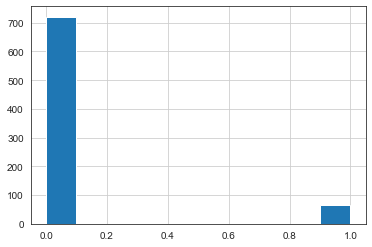

In [160]:
results_df[results_df['dif_financiacion']==1]['Success'].hist()

In [161]:
results_df[results_df['dif_financiacion']==1]['Success'].value_counts()

0    721
1     67
Name: Success, dtype: int64

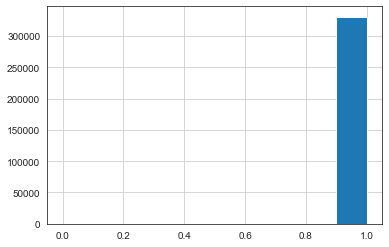

In [162]:
results_df[results_df['dif_financiacion']==0]['Success'].hist()

In [163]:
results_df[results_df['dif_financiacion']==0]['Success'].value_counts()

1    330752
0        48
Name: Success, dtype: int64

In [164]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)


In [165]:
top_features

credit_card_shift_1              0.42
loans_shift_1                    0.21
credit_card_shift_3              0.10
totalFinanciacion_shift_1        0.08
credit_card_shift_2              0.07
credit_card_shift_4              0.06
totalAssets_shift_1              0.01
dif_financiacion_shift_3         0.01
dif_credit_card_shift_2          0.01
totalAssets_shift_4              0.01
active_customer_shift_1          0.01
totalCuentas_shift_1             0.00
totalAssets_shift_3              0.00
salary                           0.00
active_customer_shift_3          0.00
active_customer_shift_2          0.00
totalIngresos_shift_4            0.00
dif_financiacion_shift_1         0.00
dif_payroll_account_shift_1      0.00
diasDesdeUltimaAltaInt_shift_3   0.00
payroll_shift_2                  0.00
entry_date_day                   0.00
diasDesdeUltimaAltaInt_shift_4   0.00
diasDesdeUltimaAltaInt_shift_1   0.00
payroll_account_shift_4          0.00
dif_payroll_shift_4              0.00
entry_date_m

In [166]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)


In [167]:
print(metrics.roc_auc_score(results_df['dif_financiacion'], results_df['AltaScore']))

0.8969465079272523


In [168]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_financiacion'], results_df['AltaScore'])

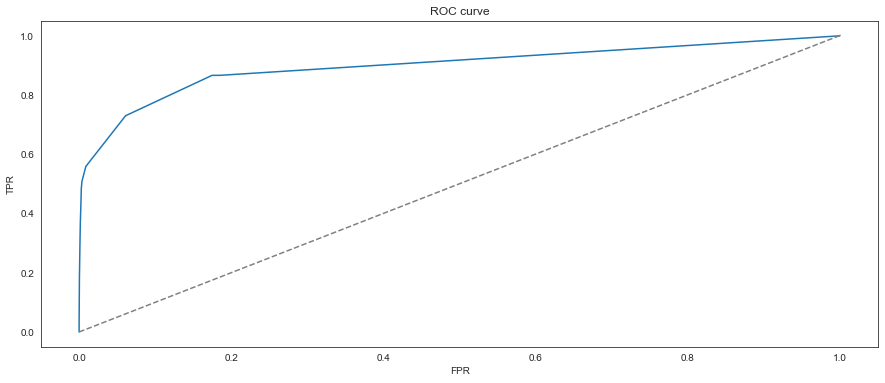

In [169]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [170]:
results_df[(results_df['dif_financiacion']!=0) &
           (results_df['AltaScore']> 0.60) ].sample(20)


,dif_financiacion,altaPrediction,Success,AltaScore
5437920,1.00,1.00,1,1.00
5341355,1.00,1.00,1,1.00
5475781,1.00,1.00,1,1.00
5323524,1.00,1.00,1,1.00
5464665,1.00,1.00,1,1.00
5389234,1.00,1.00,1,1.00
5357790,1.00,1.00,1,1.00
5390989,1.00,1.00,1,1.00
5538897,1.00,1.00,1,1.00
5383528,1.00,1.00,1,1.00


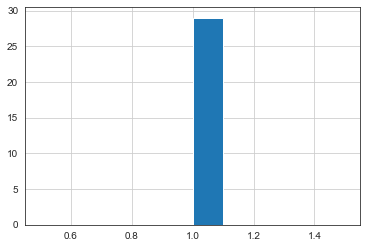

In [171]:
results_df[(results_df['dif_financiacion']!=0) &
           (results_df['AltaScore']> 0.70) ]['Success'].hist()


In [172]:
results_df[(results_df['dif_financiacion']!=0) &
           (results_df['AltaScore']> 0.70) ]['Success'].value_counts()

1    29
Name: Success, dtype: int64